# TS5

## Introducción

En el análisis de señales no determinísticas, cuando queremos conocer cómo se distribuye la potencia en frecuencia calculamos la Densidad Espectral de Potencia (PSD, Power Spectral Density), que describe cuánta potencia contiene la señal en cada banda de frecuencias.
Si $x[n]$ es una realización discreta de una señal estacionaria, su PSD teórica está relacionada con la autocorrelación $r_{xx}=[m]$ mediante el teorema de Wiener–Khinchin:

$$S_{xx}(f) = \sum_{m=-\infty}^{\infty} r_{xx}[m]\, e^{-j 2 \pi f m}$$

Los métodos de estimación espectral se dividen en dos grandes grupos:

- Métodos no paramétricos: basados en la transformada de Fourier directa o en la autocorrelación (se utilizarán: Periodograma, Welch, Blackman–Tukey).

- Métodos paramétricos: basados en modelos (AR, MA, ARMA), que no seran utilizados en este trabajo.

### Periodograma

El periodograma es la forma más simple de estimar la PSD.
Consiste en tomar la Transformada Discreta de Fourier (DFT) de la señal y calcular el módulo cuadrado:
$$\hat{S}_{xx}(f) = \frac{1}{N f_s} \, \big| X(f) \big|^2$$
donde $X(f)=DFT{x[n]}$, $N$ es el número de muestras y $f_s$ la frecuencia de muestreo.

El periodograma es insesgado (su valor medio coincide con la PSD real), pero presenta una varianza muy alta, lo que hace que la estimación sea muy ruidosa.
Además, si la señal se corta bruscamente, aparecen fugas espectrales (leakage).
Por eso se suele aplicar una ventana temporal $w[n]$ antes de la DFT:
$$\hat{S}_{xx}(f) = \frac{1}{N f_s} \, \big| \text{DFT}\{x[n] \cdot w[n]\} \big|^2$$

### Welch

El método de Welch es una mejora del periodograma que busca reducir la varianza del estimador.

Los pasos principales son:

1. Dividir la señal en segmentos (posiblemente superpuestos).
2. Aplicar una ventana $w[n]$ a cada segmento.
3. Calcular el periodograma de cada segmento.
4. Promediar los periodogramas obtenidos.


El promedio disminuye la varianza de la estimación a costa de una leve pérdida de resolución espectral.
La elección del tamaño de segmento, porcentaje de solapamiento y tipo de ventana determinan el compromiso entre resolución y varianza.

Matemáticamente:
$$\hat{S}_{xx}(f) = \frac{1}{K} \sum_{i=1}^{K} \hat{S}_{xx,i}(f)$$
donde $K$ es el número de segmentos promediados.

### Blackman-Tukey

El método de Blackman–Tukey estima la PSD a partir de la autocorrelación muestral.
Primero se calcula la autocorrelación de la señal, luego se aplica una ventana en el dominio de los retardos (lags), y al final se toma su transformada de Fourier.

1. Calcula la autocorrelación estimada (biased):
$$\hat{r}_{xx}[m] = \frac{1}{N} \sum_{n=0}^{N-1-m} x[n]\,x[n+m]$$
2. Aplica una ventana $w[n]$ sobre los retardos:
$$r_w[m] = \hat{r}_{xx}[m] \cdot w[m]$$
3. Calcula la PSD:
$$\hat{S}_{xx}(f) = \frac{1}{f_s} \sum_{m=-M}^{M} r_w[m]\, e^{-j 2 \pi f m}$$
El truncamiento y la ventana sobre $r_{xx}[m]$ suavizan la PSD (baja varianza), pero reducen la resolución en frecuencia (aumentan el sesgo).
Este método es especialmente útil cuando se quiere analizar el compromiso entre resolución y suavizado.

### Estimación del ancho de banda

Una vez obtenida la PSD, se puede estimar el ancho de banda efectivo o bandwidth de una señal como el rango de frecuencias que contiene un cierto porcentaje de la potencia total

Si $S_{xx}(f)$ es la PSD y $df$ el paso en frecuencia, la potencia total es:
$$P_\text{total} = \sum S_{xx}(f) \, \Delta f$$
La potencia acumulada se obtiene con la suma parcial, y el ancho de banda se define como la frecuencia $f_B$ donde la potencia acumulada alcanza una fracción $\alpha$ de la total.
$$\displaystyle \frac{\sum_{f=0}^{f_B} S_{xx}(f)\,\Delta f}{P_\text{total}} = \alpha$$
Este valor representa el rango de frecuencias donde se concentra la mayor parte de la energía útil de la señal.

## Código

In [9]:
import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io import wavfile

#--------------Para encontrar mi banda ancha--------------#
def estimar_BW(PSD, ff, cota):
    df = ff[1] - ff[0]
    energia_acumulada = np.cumsum(PSD * df)
    energia_total = energia_acumulada[-1]
    energia_corte = energia_total * cota
    idx_corte = np.where(energia_acumulada >= energia_corte)[0][0]
    frec_BW = ff[idx_corte]
    return frec_BW

eps = 1e-12

### ECG

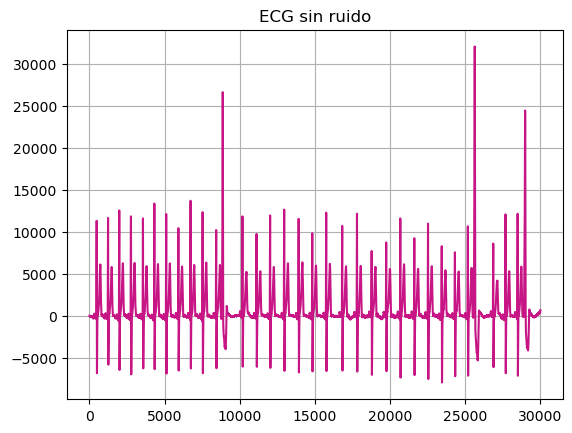

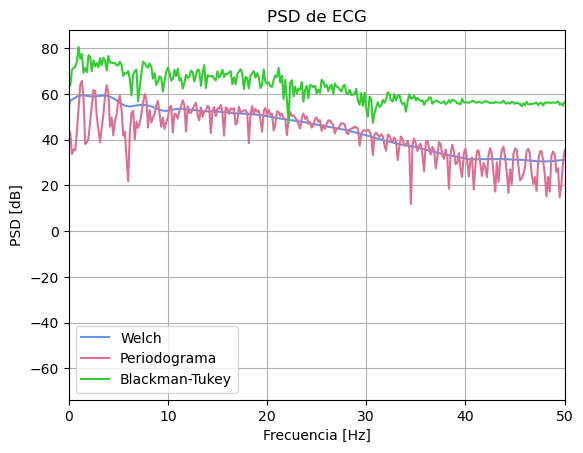

ECG
Potencia total (Welch): 7.3549e+06 V^2
BW con 95%: 22.50 Hz
BW con 97%: 25.17 Hz
BW con 99%: 30.50 Hz


In [3]:
fs_ecg = 1000
ecg = np.load('ecg_sin_ruido.npy')
N_ecg = len(ecg)

plt.figure(1)
plt.plot(ecg, color='mediumvioletred')
plt.title('ECG sin ruido')
plt.grid()
plt.show()

nperseg = N_ecg // 30
window = 'blackman'
nfft = 6 * nperseg

# Welch
freqW, ecgW = sig.welch(ecg, fs=fs_ecg, window=window, nperseg=nperseg, nfft=nfft)
# Periodograma con ventaneado
freqP, ecgP = sig.periodogram(ecg, fs=fs_ecg, window=window, nfft=nfft)
# Blackman-Tukey
corr = sig.correlate(ecg - np.mean(ecg), ecg - np.mean(ecg), mode='full')/ len(ecg) 
#lo de -np.mea es para centrar la señal antes de estimar la autocorrelación
corr = corr[corr.size // 2:]  #la mitad positiva
win_bt = sig.windows.bartlett(len(corr))
corr_win = corr * win_bt
PSD_bt = np.abs(np.fft.rfft(corr_win, n=nfft))
freqBT = np.fft.rfftfreq(nfft, d=1/fs_ecg)

plt.figure(2)
plt.plot(freqW, 10*np.log10(ecgW + eps), label='Welch', color="cornflowerblue")
plt.plot(freqP, 10*np.log10(ecgP + eps), label='Periodograma', color="palevioletred")
plt.plot(freqBT, 10*np.log10(PSD_bt + eps), label='Blackman-Tukey', color="limegreen")
plt.title('PSD de ECG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.xlim([0, 50])
plt.grid()
plt.legend()
plt.show()
# Ancho de banda y potencia total (Welch)
df = freqW[1] - freqW[0]
potTotal = np.sum(ecgW) * df
f95 = estimar_BW(ecgW, freqW, 0.95)
f97 = estimar_BW(ecgW, freqW, 0.97)
f99 = estimar_BW(ecgW, freqW, 0.99)

print("=====================================")
print("ECG")
print(f"Potencia total (Welch): {potTotal:.4e} V^2")
print(f"BW con 95%: {f95:.2f} Hz")
print(f"BW con 97%: {f97:.2f} Hz")
print(f"BW con 99%: {f99:.2f} Hz")
print("=====================================")

La mayor parte de la energia se concentra entre 0 y 30HZ, por lo que se trata de una señal de baja frecuencia y banda estrecha. Los tres métodos de estimacion se comportaron de forma con sentido, Welch muestra un resultado estable y con poca varianza, el Periodograma posee picos más ruidosos al tener la mayor varianza de los tre métodos y Blackman-Tukey parece tener un balance entre la relacion compromiso de la varianza y resolución.

### PPG

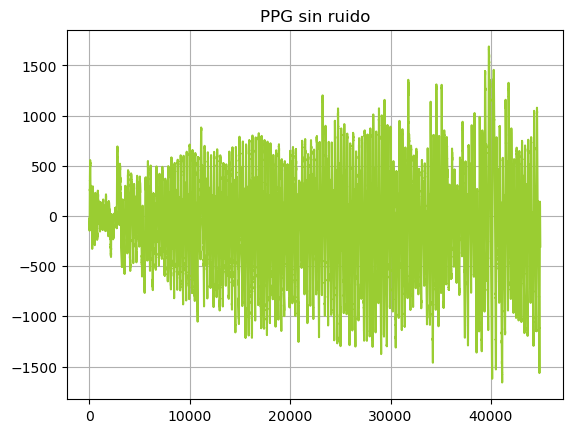

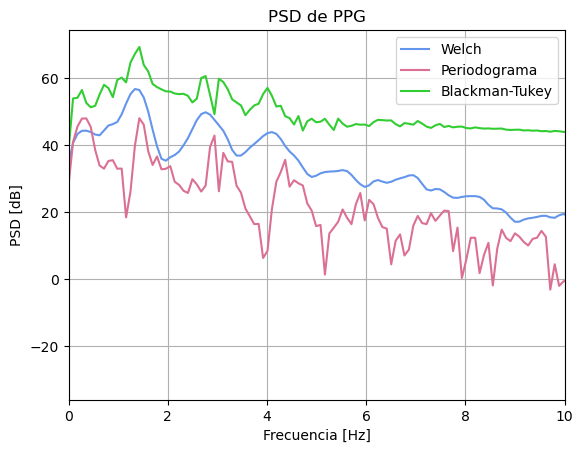

PPG
Potencia total (Welch): 2.7102e+05 V^2
BW con 95%: 4.01 Hz
BW con 97%: 4.19 Hz
BW con 99%: 5.43 Hz


In [4]:
fs_ppg = 400
ppg = np.load('ppg_sin_ruido.npy')
N_ppg = len(ppg)

plt.figure(3)
plt.plot(ppg, color='yellowgreen')
plt.title('PPG sin ruido')
plt.grid()
plt.show()

nperseg = N_ppg // 20
win = 'hann'
nfft = 2 * nperseg

freqW, ppgW = sig.welch(ppg, fs=fs_ppg, window=win, nperseg=nperseg, nfft=nfft)
freqP, ppgP = sig.periodogram(ppg, fs=fs_ppg, window=win, nfft=nfft)
corr = sig.correlate(ppg - np.mean(ppg), ppg - np.mean(ppg), mode='full')/ len(ecg)
corr = corr[corr.size // 2:]
win_bt = sig.windows.bartlett(len(corr))
corr_win = corr * win_bt
PSD_bt = np.abs(np.fft.rfft(corr_win, n=nfft))
freqBT = np.fft.rfftfreq(nfft, d=1/fs_ppg)

plt.figure(4)
plt.plot(freqW, 10*np.log10(ppgW + eps), label='Welch', color="cornflowerblue")
plt.plot(freqP, 10*np.log10(ppgP + eps), label='Periodograma', color="palevioletred")
plt.plot(freqBT, 10*np.log10(PSD_bt + eps), label='Blackman-Tukey', color="limegreen")
plt.title('PSD de PPG')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.xlim([0, 10])
plt.grid()
plt.legend()
plt.show()

df = freqW[1] - freqW[0]
potTotal = np.sum(ppgW) * df
f95 = estimar_BW(ppgW, freqW, 0.95)
f97 = estimar_BW(ppgW, freqW, 0.97)
f99 = estimar_BW(ppgW, freqW, 0.99)

print("=====================================")
print("PPG")
print(f"Potencia total (Welch): {potTotal:.4e} V^2")
print(f"BW con 95%: {f95:.2f} Hz")
print(f"BW con 97%: {f97:.2f} Hz")
print(f"BW con 99%: {f99:.2f} Hz")
print("=====================================")

Esta señal también concentra su energía en bajas frecuencias, pero con un ancho de banda mucho más pequeño (4–5 Hz), es decir, esta es una señal de baja frecuencia y un ancho de banda muy angosto. Los distintos métodos mantienen la forma general de relacion varianza-resolución, Welch se ve suave sin mucha varianza, el Periodograma muestra la mayor fluctuación y Blackman–Tukey sigue siendo el que mejor comprimiso demuestra.

### Audio

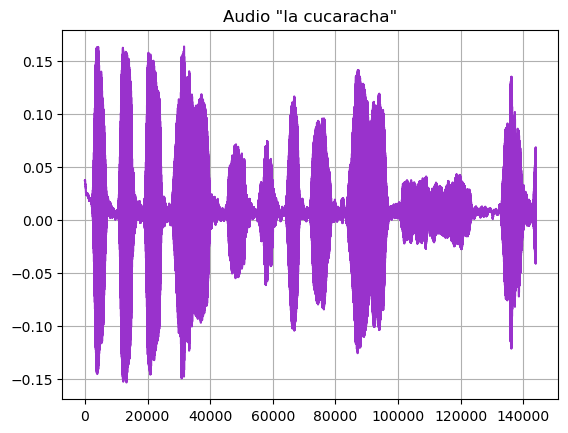

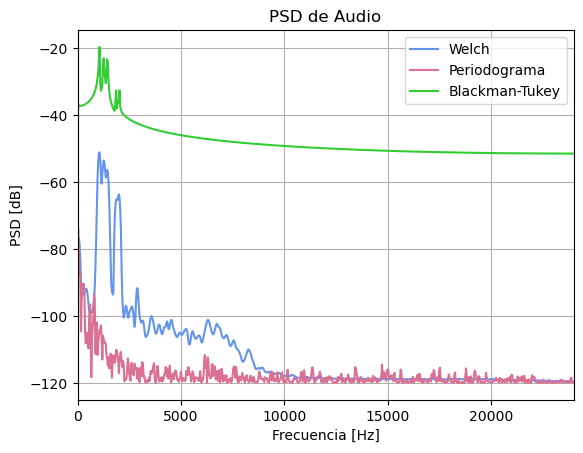

AUDIO
Potencia total (Welch): 1.8211e-03 V^2
BW con 95%: 1533.33 Hz
BW con 97%: 1900.00 Hz
BW con 99%: 2000.00 Hz


In [5]:
fs_audio, audio = wavfile.read('la cucaracha.wav')
if audio.ndim > 1:
    audio = audio[:,0]
N_aud = len(audio)

plt.figure(5)
plt.plot(audio, color='darkorchid')
plt.title('Audio "la cucaracha"')
plt.grid()
plt.show()

nperseg = N_aud // 200
win = 'hann'
nfft = 2 * nperseg

freqW, audW = sig.welch(audio, fs=fs_audio, window=win, nperseg=nperseg, nfft=nfft)
freqP, audP = sig.periodogram(audio, fs=fs_audio, window=win, nfft=nfft)
corr = sig.correlate(audio - np.mean(audio), audio - np.mean(audio), mode='full')/ len(ecg)
corr = corr[corr.size // 2:]
win_bt = sig.windows.bartlett(len(corr))
corr_win = corr * win_bt
PSD_bt = np.abs(np.fft.rfft(corr_win, n=nfft))
freqBT = np.fft.rfftfreq(nfft, d=1/fs_audio)

plt.figure(6)
plt.plot(freqW, 10*np.log10(audW + eps), label='Welch', color="cornflowerblue")
plt.plot(freqP, 10*np.log10(audP + eps), label='Periodograma', color="palevioletred")
plt.plot(freqBT, 10*np.log10(PSD_bt + eps), label='Blackman-Tukey', color="limegreen")
plt.title('PSD de Audio')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.xlim([0, fs_audio/2])
plt.grid()
plt.legend()
plt.show()

df = freqW[1] - freqW[0]
potTotal = np.sum(audW) * df
f95 = estimar_BW(audW, freqW, 0.95)
f97 = estimar_BW(audW, freqW, 0.97)
f99 = estimar_BW(audW, freqW, 0.99)

print("=====================================")
print("AUDIO")
print(f"Potencia total (Welch): {potTotal:.4e} V^2")
print(f"BW con 95%: {f95:.2f} Hz")
print(f"BW con 97%: {f97:.2f} Hz")
print(f"BW con 99%: {f99:.2f} Hz")
print("=====================================")

En este caso, la señal de audio muestra un ancho de banda de hasta 2 kHz (99 % de energía). A diferencia de las señales fisiológicas, esta señal es de banda ancha grande y alta variabilidad espectral. Respecto a los métodos utilizados, en el caso del audio estos varian respecto a las dos señales analizadas anteriormente, Welch ya no es el método con menor varianza, ahora Blackman-Tukey es el que menor varianza muestra, welch se convierte en el método que mejor relacion varianza-resolucion tiene de los tres, y por ultimo el periodograma al igual que en las demas señales, es el que mayor varianza presenta de todos, incluso parece tener mas varianza que en los demas ejemplos.

## Bonus

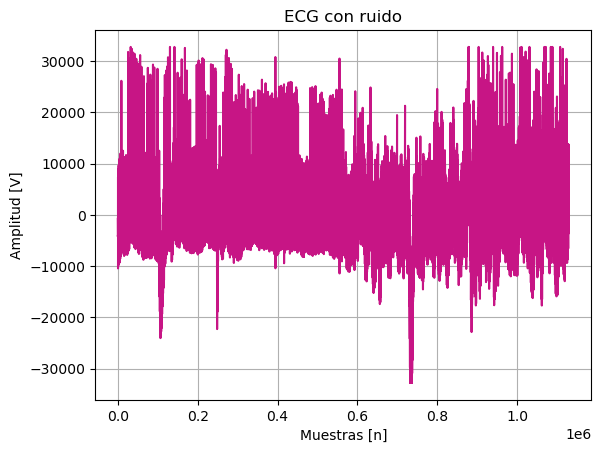

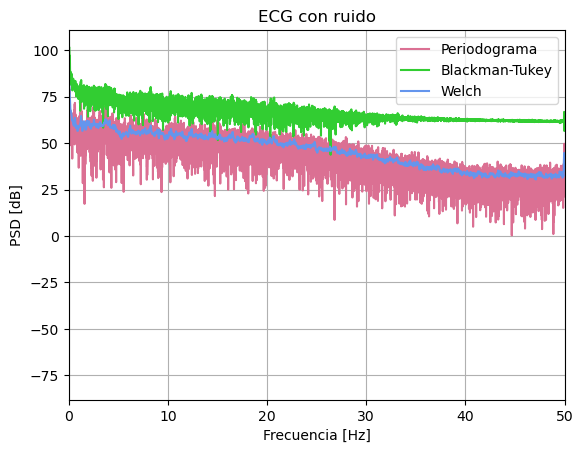

ECG CON RUIDO
Potencia total (Welch): 2.2174e+07 V^2
BW con 95%: 17.93 Hz
BW con 97%: 20.78 Hz
BW con 99%: 26.90 Hz


In [10]:
##################
## ECG con ruido
##################

# para listar las variables que hay en el archivo
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_ruido = mat_struct['ecg_lead'].flatten()  # señal con ruido (1D)
N_ecg_ruido = len(ecg_ruido)

hb_1 = mat_struct['heartbeat_pattern1']
hb_2 = mat_struct['heartbeat_pattern2']

plt.figure(7)
plt.plot(ecg_ruido, color='mediumvioletred')
plt.title('ECG con ruido')
plt.xlabel('Muestras [n]')
plt.ylabel('Amplitud [V]')
plt.grid()
plt.show()

# Parámetros (idénticos a los del ECG sin ruido)
nperseg = N_ecg_ruido // 30
window = 'blackman'
nfft = 6 * nperseg

# Welch
freqW_r, ecgW_r = sig.welch(ecg_ruido, fs=fs_ecg, window=window, nperseg=nperseg, nfft=nfft)

# Periodograma
freqP_r, ecgP_r = sig.periodogram(ecg_ruido, fs=fs_ecg, window=window, nfft=nfft)

# Blackman–Tukey
corr_r = sig.correlate(ecg_ruido - np.mean(ecg_ruido), ecg_ruido - np.mean(ecg_ruido), mode='full') / N_ecg_ruido
corr_r = corr_r[corr_r.size // 2:]
win_bt = sig.windows.bartlett(len(corr_r))
corr_win_r = corr_r * win_bt
PSD_bt_r = np.abs(np.fft.rfft(corr_win_r, n=nfft))
freqBT_r = np.fft.rfftfreq(nfft, d=1/fs_ecg)

# ---- Gráfico ----
plt.figure(8)
plt.plot(freqP_r, 10*np.log10(ecgP_r + eps), label='Periodograma', color="palevioletred")
plt.plot(freqBT_r, 10*np.log10(PSD_bt_r + eps), label='Blackman-Tukey', color="limegreen")
plt.plot(freqW_r, 10*np.log10(ecgW_r + eps), label='Welch', color="cornflowerblue")
plt.title('ECG con ruido')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.xlim([0, 50])
plt.grid()
plt.legend()
plt.show()

# ---- Potencia total y ancho de banda ----
df_r = freqW_r[1] - freqW_r[0]
potTotal_r = np.sum(ecgW_r) * df_r
f95_r = estimar_BW(ecgW_r, freqW_r, 0.95)
f97_r = estimar_BW(ecgW_r, freqW_r, 0.97)
f99_r = estimar_BW(ecgW_r, freqW_r, 0.99)

print("=====================================")
print("ECG CON RUIDO")
print(f"Potencia total (Welch): {potTotal_r:.4e} V^2")
print(f"BW con 95%: {f95_r:.2f} Hz")
print(f"BW con 97%: {f97_r:.2f} Hz")
print(f"BW con 99%: {f99_r:.2f} Hz")
print("=====================================")






Al analizar la señal de ECG contaminada con ruido mediante los tres métodos se pudo ver que en los gráficos obtenido el periodograma presenta una gran variabilidad punto a punto, dando a enteder que posee una varianza alta, aunque ofrece una buena resolución espectral al distinguir componentes finas. El método de Welch, al promediar varios periodogramas de segmentos superpuestos, redujo significativamente la varianza a costa de una menor resolución espectral, generando una estimación más suave y estable. Finalmente, el método de Blackman–Tukey utiliza la autocorrelación truncada y suavizada por una ventana, logrando un compromiso intermedio entre varianza y resolución. En conjunto, el análisis muestra cómo la elección del método implica un compromiso entre la estabilidad la precisión en frecuencia, siendo Welch el mejor frente al ruido en este caso.

## Conclusiones